# Imports

In [55]:
# standard
    # arrays & train
import pandas as pd
import numpy as np
    # stats
from scipy import stats
    # access
import os
import requests
    # random
import random

# vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
    # regex
import re
import unicodedata
import nltk
    # tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
    # stopwords
from nltk.corpus import stopwords
    # web scraper
from bs4 import BeautifulSoup
    # ?
from wordcloud import WordCloud

# modeling
    # sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
# scripts
import wrangle as w
import env
# ignore
import warnings
warnings.filterwarnings("ignore")


## Acquire

In [56]:
df = w.process_all_repos()

## Prepare

##### Prepare Steps:
- Lowercase All Text
- Remove accented characters and non-ASCII characters
- Remove special characters
- Tokenize
- Lemmatize
- Remove Stopwords
- Add extra Stopwords

### Extra stopword manipulation

In [57]:
extra_stop_words = pd.read_csv('extra_stop_words.csv')
extra_stop_words = extra_stop_words['0'].to_list()

In [58]:
df = w.transform_data(df, extra_stopwords=extra_stop_words)

### Split

In [59]:
train, test = train_test_split(df, train_size=.8, random_state=666)

## Explore

In [60]:
# List lema will be lematized words in list format
c = []
for i, val in enumerate(train.lematized):
     c.append(val.split())
train['list_lema'] = c

In [61]:
train['len_lematized'] = train['lematized'].str.len()

Checking distributions of Python:


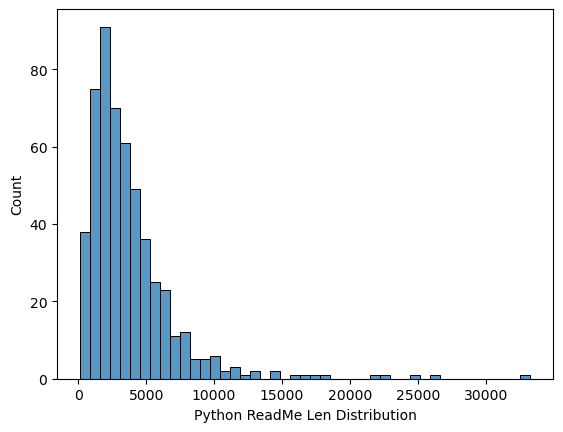

+ + + + + + + + + + + + + + + +
Checking distributions of C++:


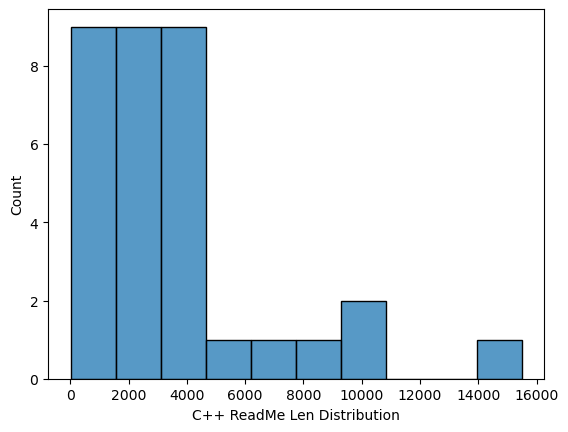

+ + + + + + + + + + + + + + + +
Checking distributions of Other:


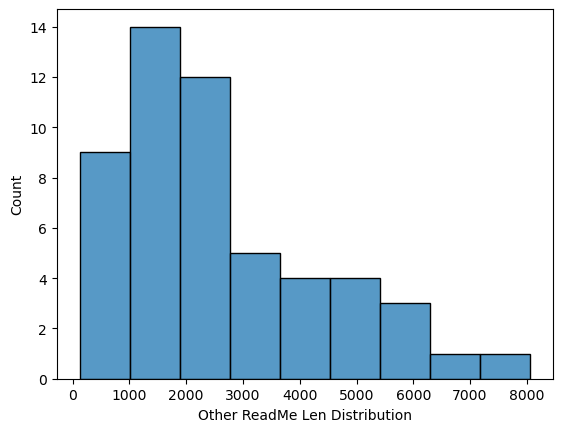

+ + + + + + + + + + + + + + + +
Checking distributions of Markdown:


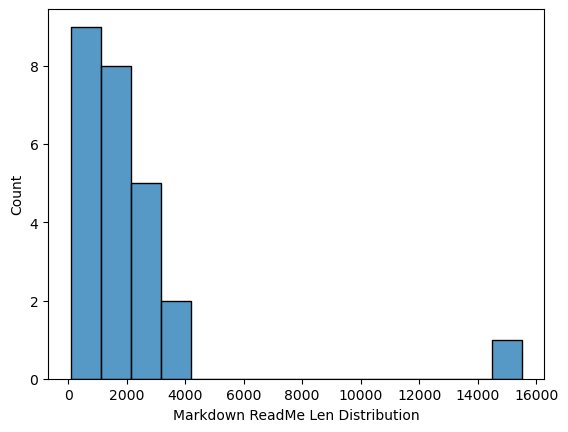

+ + + + + + + + + + + + + + + +
Checking distributions of All:


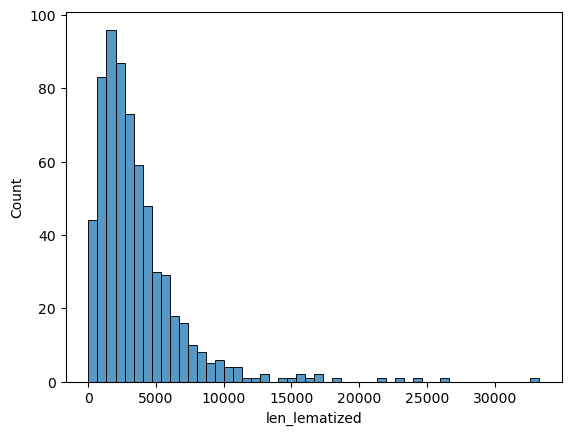

+ + + + + + + + + + + + + + + +


In [62]:
# Checking readme word len distributions
w.language_distributions(train)

## The distributions of word count in all languages is *inverse gausian-like*, the variations is in volume of readmes

In [63]:
# getting all words joined for each language
py_words = ' '.join(train[train.language == 'Python'].lematized)
c_words = ' '.join(train[train.language == 'C++'].lematized)
mark_words = ' '.join(train[train.language == 'Markdown'].lematized)
other_words = ' '.join(train[train.language == 'Other'].lematized)
all_words = ' '.join(train.lematized)

In [64]:
# Get word counts for each language
py_counts =pd.Series(py_words.split()).value_counts()
c_counts =pd.Series(c_words.split()).value_counts()
mark_counts =pd.Series(mark_words.split()).value_counts()
other_counts =pd.Series(other_words.split()).value_counts()
all_counts =pd.Series(all_words.split()).value_counts()

In [65]:
#Combine the value counts into one dataframe
word_counts = pd.concat([py_counts, c_counts, mark_counts, all_counts], axis=1)
word_counts.columns = ['py_counts', 'c_counts', 'mark_counts', 'all_counts']

# Fill the nulls with 0
word_counts.fillna(0, inplace=True)
#Recast all columns as integers
word_counts = word_counts.astype('int')

#take a look
word_counts.head()

,py_counts,c_counts,mark_counts,all_counts
model,4241,126,46,4556
python,2495,105,5,2701
data,2414,96,116,2768
training,1993,72,18,2138
file,1849,101,105,2185


### Additional Stopwords Catch

In [66]:
# this is how we will reduce some junk words that are not any language
additional_stop_words = word_counts[word_counts.all_counts == 1].index.tolist()
# pd.Series(additional_stop_words).to_csv('extra_stop_words.csv')

In [67]:
all_counts

model          4556
data           2768
python         2701
file           2185
training       2138
               ... 
width350px        1
encorewebmd       1
beed              1
pythonexe         1
181004805         1
Name: count, Length: 18353, dtype: int64

In [68]:
# What are the most frequent py words?
py_counts.head()

model       4241
python      2495
data        2414
training    1993
file        1849
Name: count, dtype: int64

In [69]:
# What are the most frequent c words?
c_counts.head()

model      126
install    125
example    124
python     105
file       101
Name: count, dtype: int64

In [70]:
# What are the most frequent Markdown words?
mark_counts.head()

data           116
file           105
dataset         91
contains        76
participant     68
Name: count, dtype: int64

<div class="alert alert-block alert-info"> 
<b>Takeaway:</b>
    
- Words like 
- Words like 
</div>

In [71]:
# Get word frequencies for each language
py_freq =pd.Series(py_words.split()).value_counts(normalize=True)* 100
c_freq = pd.Series(c_words.split()).value_counts(normalize=True)* 100
mark_freq = pd.Series(mark_words.split()).value_counts(normalize=True)* 100
other_freq = pd.Series(other_words.split()).value_counts(normalize=True)* 100
all_freq = pd.Series(all_words.split()).value_counts(normalize=True)* 100

In [72]:
#Combine the value counts into one dataframe
word_freq = pd.concat([py_freq, c_freq, mark_freq, all_freq], axis=1)
word_freq.columns = ['py_freq', 'c_freq', 'mark_freq', 'all_freq']

# Fill the nulls with 0
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,py_freq,c_freq,mark_freq,all_freq
model,1.539484,0.770972,0.629361,1.432421
python,0.905685,0.642477,0.068409,0.849203
data,0.876282,0.587407,1.587084,0.870268
training,0.723459,0.440556,0.246272,0.672194
file,0.671187,0.618002,1.436585,0.686971


# Explore Questions:
#### Looking at **most** frequent word of Python:

### 1. Is `'model'` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between model and Python
- $H_a$: There is a relationship between model and Python

#### Steps:
- 1a. Engineer column that counts `'model'` within every value
- 1b. Compare that by language


In [73]:
# engineer column that counts 'model' within every value
    # chi2
train['has_model'] = train.lematized.str.contains('model').astype(int)
has_model_python = train.has_model[train['language'] == 'Python']
    # mann-whitney
train['model_count'] = train.lematized.str.count('model')
model_python = train.model_count[train['language'] == 'Python']
model_other = train.model_count[train['language'] != 'Python']

In [74]:
# running a chi2 test based on whether or not the str contains model or not
w.chi2_test(has_model_python,train['has_model'],contingency=True)

We can reject the null hypothesis with a p-score of: {5.952757601430848e-115}


has_model,0,1
has_model,,
0,96,0
1,0,430


In [75]:
# running mann-whitney on model count in python vs all
w.two_samp(model_python, model_other, normal=False)

We can reject the null hypothesis with a p-score of: {7.0741806380556314e-15}


### We can see that there is a relationship between `'model'` and `'Python'`

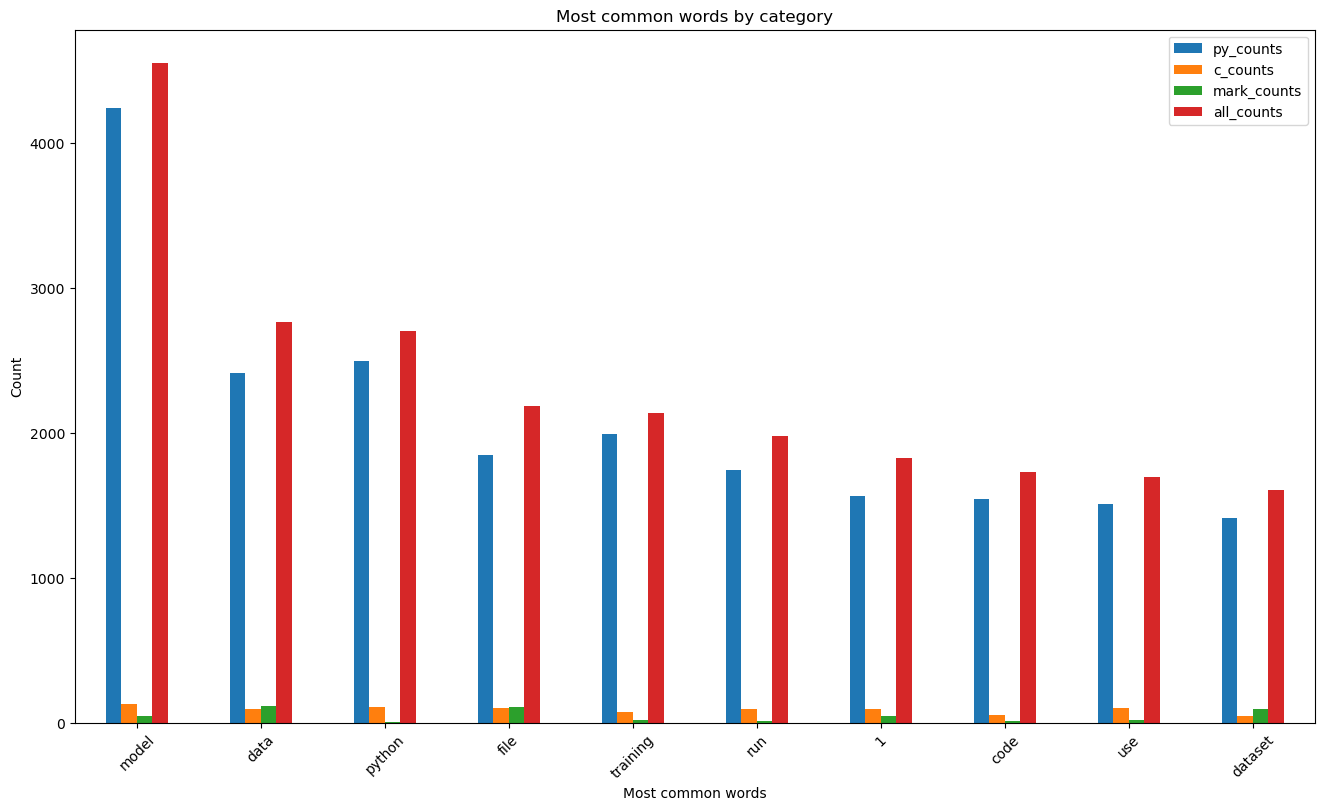

In [76]:
#Plot the most frequent words and color by label
word_counts.sort_values('all_counts', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

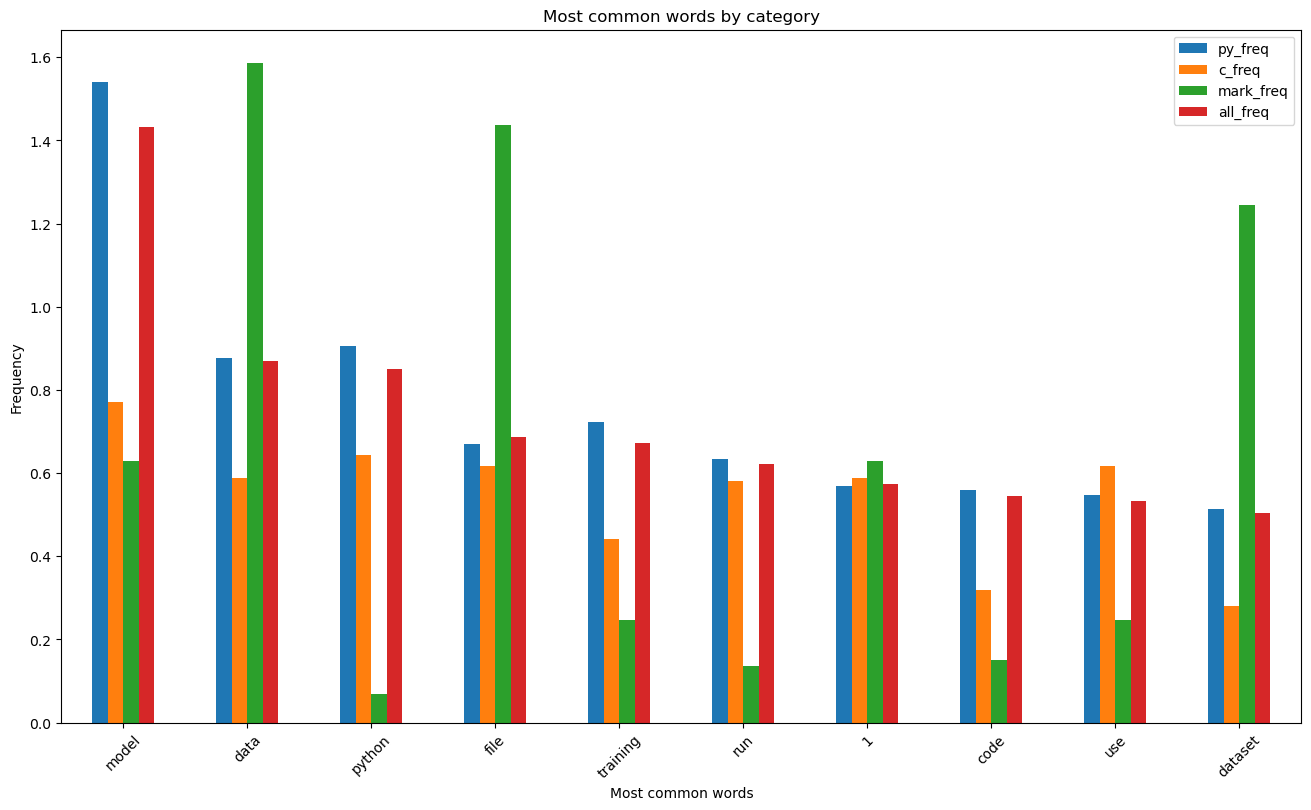

In [77]:
#Plot the most frequent words and color by label
word_freq.sort_values('all_freq', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

In [78]:
# Create dataframe with the word counts and frequencies for each language
words = pd.concat([word_counts, word_freq], axis=1)

In [79]:
# Look at the highest percent python words
words.sort_values('py_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
model,4241,126,46,4556,1.539484,0.770972,0.629361,1.432421
python,2495,105,5,2701,0.905685,0.642477,0.068409,0.849203
data,2414,96,116,2768,0.876282,0.587407,1.587084,0.870268
training,1993,72,18,2138,0.723459,0.440556,0.246272,0.672194
file,1849,101,105,2185,0.671187,0.618002,1.436585,0.686971
run,1747,95,10,1978,0.634161,0.581289,0.136818,0.621889
1,1567,96,46,1828,0.568821,0.587407,0.629361,0.574729
code,1541,52,11,1730,0.559383,0.318179,0.150499,0.543917
use,1509,101,18,1699,0.547767,0.618002,0.246272,0.534171
dataset,1416,46,91,1603,0.514008,0.281466,1.245040,0.503988


In [80]:
# Look at the highest percent c words
words.sort_values('c_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
model,4241,126,46,4556,1.539484,0.770972,0.629361,1.432421
install,1381,125,5,1578,0.501303,0.764853,0.068409,0.496128
example,1140,124,8,1361,0.413820,0.758735,0.109454,0.427903
python,2495,105,5,2701,0.905685,0.642477,0.068409,0.849203
file,1849,101,105,2185,0.671187,0.618002,1.436585,0.686971
use,1509,101,18,1699,0.547767,0.618002,0.246272,0.534171
build,174,98,4,347,0.063162,0.599645,0.054727,0.109098
x,175,97,8,310,0.063525,0.593526,0.109454,0.097465
data,2414,96,116,2768,0.876282,0.587407,1.587084,0.870268
1,1567,96,46,1828,0.568821,0.587407,0.629361,0.574729


In [81]:
# Look at the highest percent markdown words
words.sort_values('mark_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
data,2414,96,116,2768,0.876282,0.587407,1.587084,0.870268
file,1849,101,105,2185,0.671187,0.618002,1.436585,0.686971
dataset,1416,46,91,1603,0.514008,0.281466,1.245040,0.503988
contains,412,26,76,566,0.149556,0.159090,1.039814,0.177952
participant,20,0,68,92,0.007260,0.000000,0.930360,0.028925
directory,495,23,63,615,0.179685,0.140733,0.861951,0.193358
model,4241,126,46,4556,1.539484,0.770972,0.629361,1.432421
1,1567,96,46,1828,0.568821,0.587407,0.629361,0.574729
session,32,0,44,78,0.011616,0.000000,0.601998,0.024523
language,438,6,44,524,0.158994,0.036713,0.601998,0.164747


## N-Grams
### Bigrams

In [82]:
# Bigrams!
all_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2)))
py_bigrams = (pd.Series(nltk.ngrams(py_words.split(), 2)))
c_bigrams = (pd.Series(nltk.ngrams(c_words.split(), 2)))
mark_bigrams = (pd.Series(nltk.ngrams(mark_words.split(), 2)))
other_bigrams = (pd.Series(nltk.ngrams(other_words.split(), 2)))

# Top 20 most common bigrams
top_20_all_bigrams = all_bigrams.value_counts().head(20)
top_20_py_bigrams = py_bigrams.value_counts().head(20)
top_20_c_bigrams = c_bigrams.value_counts().head(20)
top_20_mark_bigrams = mark_bigrams.value_counts().head(20)
top_20_other_bigrams = other_bigrams.value_counts().head(20)

# Get bigram counts for each language
al_bigram_counts = all_bigrams.value_counts()
py_bigram_counts = py_bigrams.value_counts()
c_bigram_counts = c_bigrams.value_counts()
mark_bigram_counts = mark_bigrams.value_counts()
other_bigram_counts = other_bigrams.value_counts()

# Get bigram frequencies for each language
al_bigram_freq = all_bigrams.value_counts(normalize=True)*100
py_bigram_freq = py_bigrams.value_counts(normalize=True)*100
c_bigram_freq = c_bigrams.value_counts(normalize=True)*100
mark_bigram_freq = mark_bigrams.value_counts(normalize=True)*100
other_bigram_freq = other_bigrams.value_counts(normalize=True)*100

# Combine bigram counts into one dataframe
bigram_counts = pd.concat([al_bigram_counts, py_bigram_counts, c_bigram_counts, mark_bigram_counts, other_bigram_counts], axis=1).fillna(0).astype(int)
bigram_counts.columns = ['all_bigram_count', 'py_bigram_count', 'c_bigram_count', 'mark_bigram_count', 'other_bigram_count']

# Combine bigram frequencies into one dataframe
bigram_freq = pd.concat([al_bigram_freq, py_bigram_freq, c_bigram_freq, mark_bigram_freq, other_bigram_freq], axis=1).fillna(0)
bigram_freq.columns = ['all_bigram_freq', 'py_bigram_freq', 'c_bigram_freq', 'mark_bigram_freq', 'other_bigram_freq']

# Combine bigram count and frequency dataframes
bigrams = pd.concat([bigram_counts, bigram_freq], axis=1)
bigrams.head()

,,all_bigram_count,py_bigram_count,c_bigram_count,mark_bigram_count,other_bigram_count,all_bigram_freq,py_bigram_freq,c_bigram_freq,mark_bigram_freq,other_bigram_freq
pip,install,578,554,13,1,10,0.181726,0.201103,0.079550,0.013684,0.052832
arrival,dictionary,360,360,0,0,0,0.113185,0.130681,0.000000,0.000000,0.000000
pre,trained,355,338,3,1,13,0.111613,0.122694,0.018358,0.013684,0.068681
bash,python,307,298,5,0,4,0.096522,0.108174,0.030596,0.000000,0.021133
trained,model,298,278,5,2,13,0.093692,0.100914,0.030596,0.027367,0.068681


### Trigrams

In [83]:
# Trigrams!
all_trigrams = (pd.Series(nltk.ngrams(all_words.split(), 3)))
py_trigrams = (pd.Series(nltk.ngrams(py_words.split(), 3)))
c_trigrams = (pd.Series(nltk.ngrams(c_words.split(), 3)))
mark_trigrams = (pd.Series(nltk.ngrams(mark_words.split(), 3)))
other_trigrams = (pd.Series(nltk.ngrams(other_words.split(), 3)))

# Top 20 most common trigrams
top_20_all_trigrams = all_trigrams.value_counts().head(20)
top_20_py_trigrams = py_trigrams.value_counts().head(20)
top_20_c_trigrams = c_trigrams.value_counts().head(20)
top_20_mark_trigrams = mark_trigrams.value_counts().head(20)
top_20_other_trigrams = other_trigrams.value_counts().head(20)

# Get trigram counts for each language
al_trigram_counts = all_trigrams.value_counts()
py_trigram_counts = py_trigrams.value_counts()
c_trigram_counts = c_trigrams.value_counts()
mark_trigram_counts = mark_trigrams.value_counts()
other_trigram_counts = other_trigrams.value_counts()

# Get trigram frequencies for each language
al_trigram_freq = all_trigrams.value_counts(normalize=True)*100
py_trigram_freq = py_trigrams.value_counts(normalize=True)*100
c_trigram_freq = c_trigrams.value_counts(normalize=True)*100
mark_trigram_freq = mark_trigrams.value_counts(normalize=True)*100
other_trigram_freq = other_trigrams.value_counts(normalize=True)*100

# Combine trigram counts into one dataframe
trigram_counts = pd.concat([al_trigram_counts, py_trigram_counts, c_trigram_counts, mark_trigram_counts, other_trigram_counts], axis=1).fillna(0).astype(int)
trigram_counts.columns = ['all_trigram_count', 'py_trigram_count', 'c_trigram_count', 'mark_trigram_count', 'other_trigram_count']

# Combine trigram frequencies into one dataframe
trigram_freq = pd.concat([al_trigram_freq, py_trigram_freq, c_trigram_freq, mark_trigram_freq, other_trigram_freq], axis=1).fillna(0)
trigram_freq.columns = ['all_trigram_freq', 'py_trigram_freq', 'c_trigram_freq', 'mark_trigram_freq', 'other_trigram_freq']

# Combine trigram count and frequency dataframes
trigrams = pd.concat([trigram_counts, trigram_freq], axis=1)
trigrams.head()

,,,all_trigram_count,py_trigram_count,c_trigram_count,mark_trigram_count,other_trigram_count,all_trigram_freq,py_trigram_freq,c_trigram_freq,mark_trigram_freq,other_trigram_freq
b,b,b,202,202,0,0,0,0.063510,0.073327,0.000000,0.000000,0.000000
pre,trained,model,185,173,2,1,9,0.058165,0.062799,0.012239,0.013686,0.047551
arrival,dictionary,en,153,153,0,0,0,0.048104,0.055539,0.000000,0.000000,0.000000
p,aligncenter,img,135,126,2,5,2,0.042445,0.045738,0.012239,0.068428,0.010567
testhttps,arrival,dictionary,120,120,0,0,0,0.037729,0.043560,0.000000,0.000000,0.000000


<Axes: >

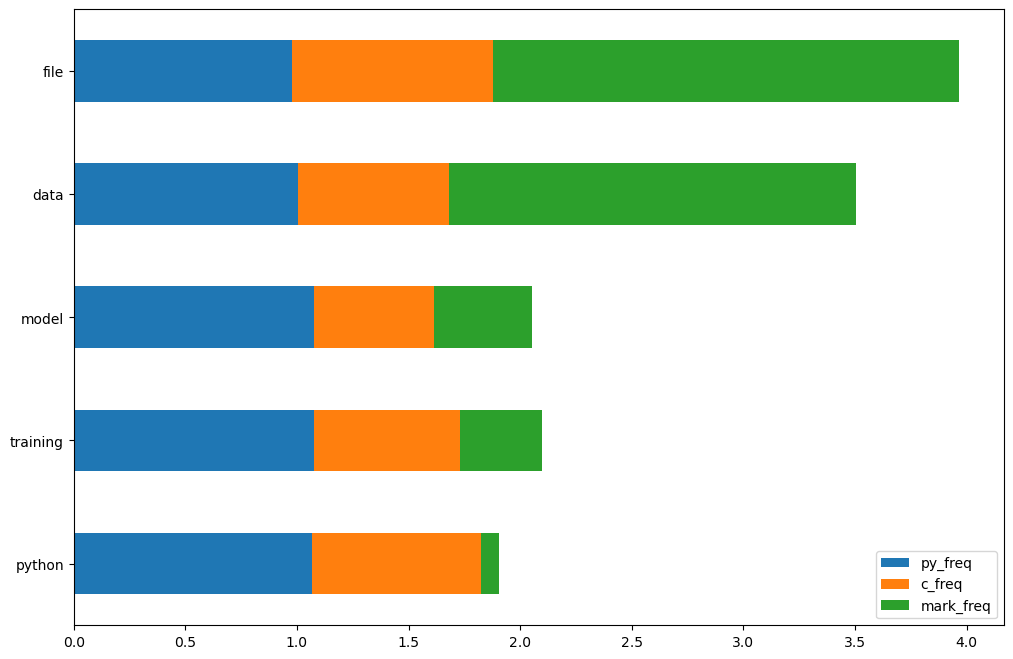

In [84]:
# Visualize language bigrams as percent of all word counts
(word_freq.sort_values(by='all_freq', ascending=False)
    .head()
    .apply(lambda row: row / row['all_freq'], axis=1)
    .drop(columns=['all_freq'])
    .sort_values(by='mark_freq')
    .plot.barh(stacked=True, figsize=(12, 8)))

#### Looking at **most** frequent *bigram* of Python:

### 2. Is `('pip', 'install')` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between `('pip', 'install')` and Python
- $H_a$: There is a relationship between `('pip', 'install')` and Python

#### Steps:
- 1a. Create visualization that shows counts of all languages most frequent bigrams


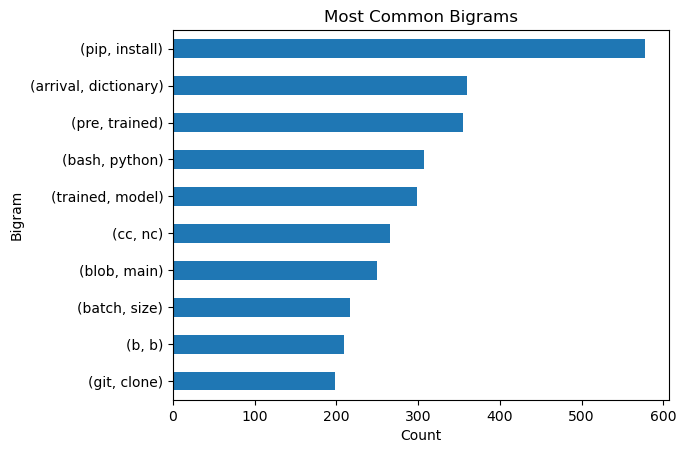

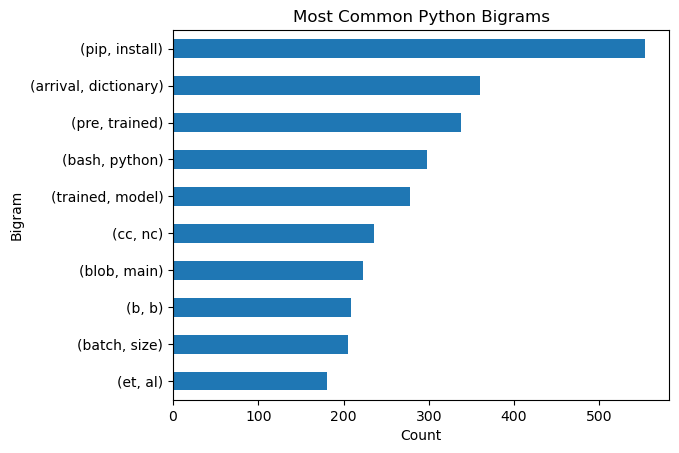

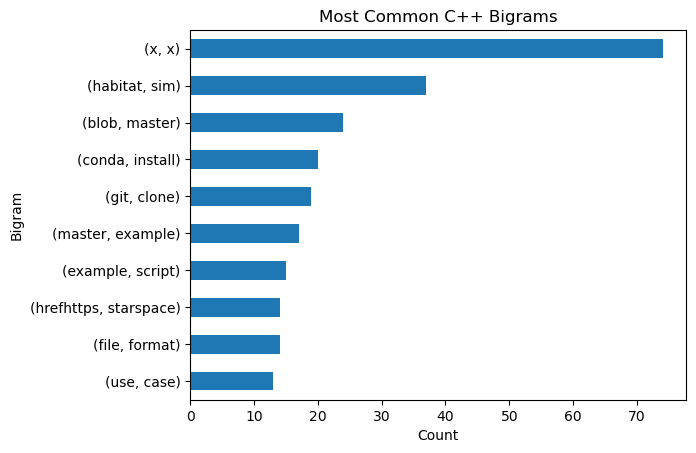

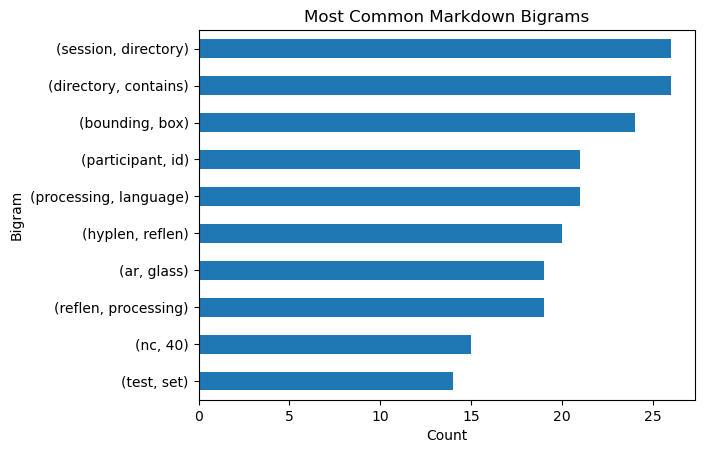

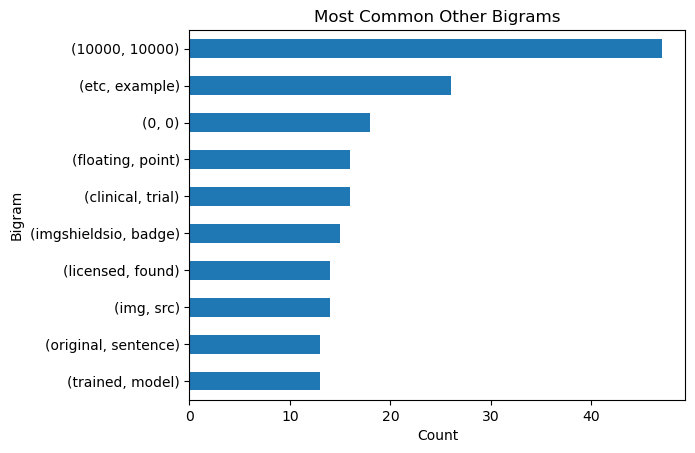

In [85]:
top_20_all_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Bigrams')
plt.show()

top_20_py_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Bigrams')
plt.show()

top_20_c_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Bigrams')
plt.show()

top_20_mark_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Bigrams')
plt.show()

top_20_other_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Bigrams')
plt.show()

## Question 2 Answer:
    We can see the bigram `('pip','install')` values shows up in 'python' ~530 times and about ~550 in all languages.

    Although only visually confirming -- naturalistically we will assume that this bigram has some sort of relationship to Python.

#### Looking at **most** frequent *trigram* of Python:

### 3. Is `('pre','trained','model')` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between `('pre','trained','model')` and Python
- $H_a$: There is a relationship between `('pre','trained','model')` and Python

#### Steps:
- 1a. Engineer column that counts `('pre','trained','model')` within every value

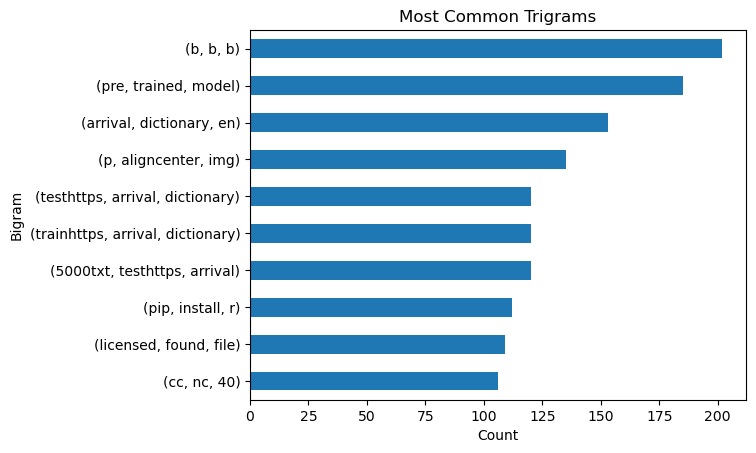

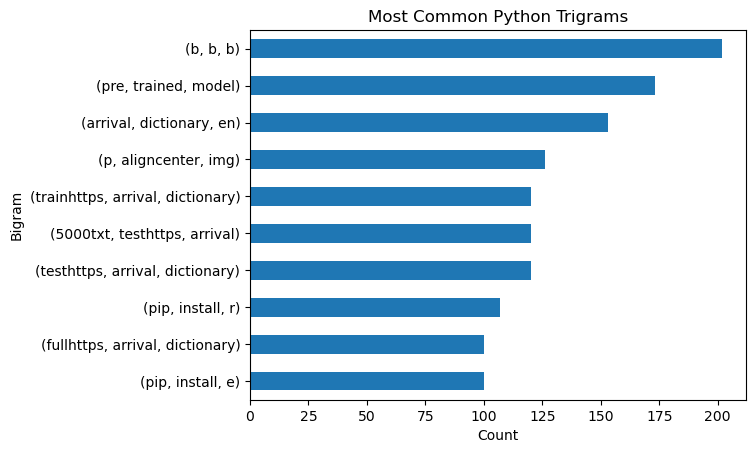

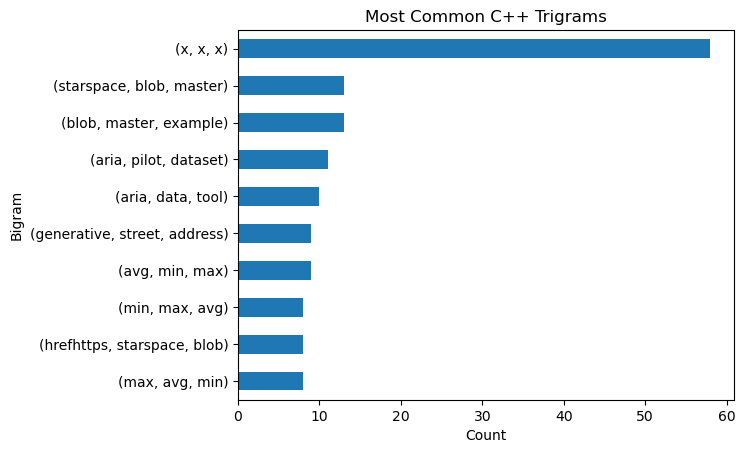

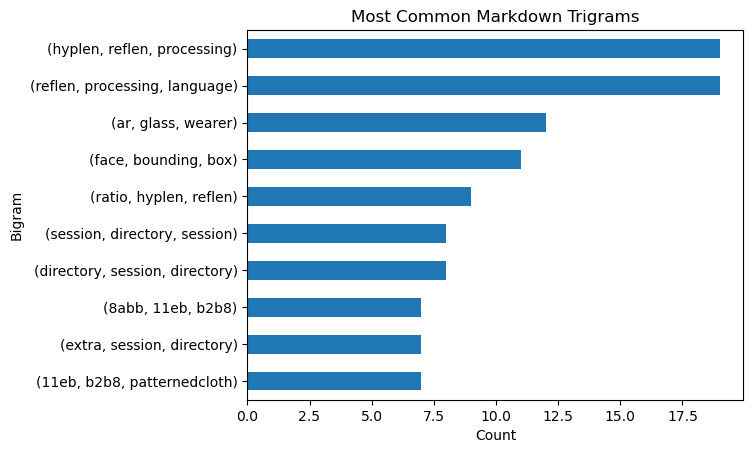

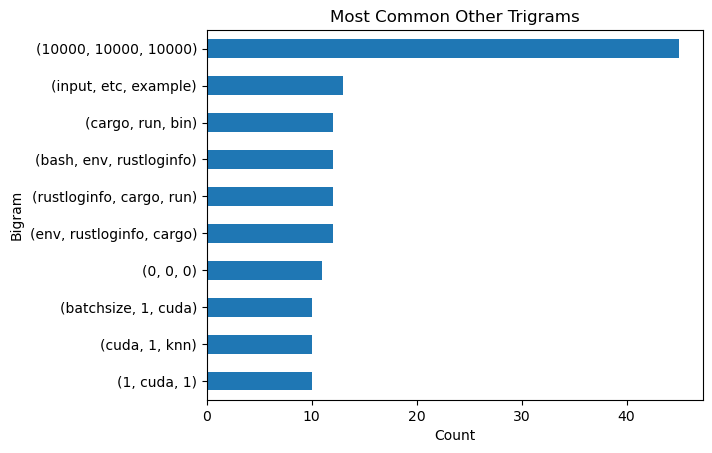

In [86]:
top_20_all_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Trigrams')
plt.show()

top_20_py_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Trigrams')
plt.show()

top_20_c_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Trigrams')
plt.show()

top_20_mark_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Trigrams')
plt.show()

top_20_other_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Trigrams')
plt.show()

## Modeling

### Baseline:

Baseline Prediction - Python \
Baseline Accuracy - 82.57%

### Model 1: Logistic Regression

In [87]:
train, test = train_test_split(df, train_size=.6, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of n-grams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 82.43%
---
Confusion Matrix
actual     C++       Markdown  Other     Python  
predicted                                        
Python           24        20        40       394
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00        24
    Markdown       0.00      0.00      0.00        20
       Other       0.00      0.00      0.00        40
      Python       0.82      1.00      0.90       394

    accuracy                           0.82       478
   macro avg       0.21      0.25      0.23       478
weighted avg       0.68      0.82      0.74       478



### Model 2: Decision Tree Classifier (Specified Features)

Features = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']

In [88]:
# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.7, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of unigrams, bigrams, and trigrams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']

tfidf = TfidfVectorizer(vocabulary=specific_ngrams)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=666, max_depth=2)
dt.fit(X_train, y_train)

# Make predictions on the training and test data
train_predicted = dt.predict(X_train)
test_predicted = dt.predict(X_test)

# Evaluate the Decision Tree classifier
print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, train_predicted)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, test_predicted)))
print('---')
print('Confusion Matrix')
print(confusion_matrix(y_test, test_predicted))
print('---')
print(classification_report(y_test, test_predicted))

Training Accuracy: 82.76%
Test Accuracy: 82.08%
---
Confusion Matrix
[[  0   0   0   8]
 [  0   5   0   4]
 [  0   1   0  26]
 [  0   4   0 192]]
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         8
    Markdown       0.50      0.56      0.53         9
       Other       0.00      0.00      0.00        27
      Python       0.83      0.98      0.90       196

    accuracy                           0.82       240
   macro avg       0.33      0.38      0.36       240
weighted avg       0.70      0.82      0.76       240



### Model 3: Decision Tree Classifier 

In [89]:
# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.7, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=666, max_depth=2)
dt.fit(X_train, y_train)

# Make predictions on the training and test data
train_predicted = dt.predict(X_train)
test_predicted = dt.predict(X_test)

# Evaluate the Decision Tree classifier
print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, train_predicted)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, test_predicted)))
print('---')
print('Confusion Matrix')
print(confusion_matrix(y_test, test_predicted))
print('---')
print(classification_report(y_test, test_predicted))

Training Accuracy: 84.38%
Test Accuracy: 84.58%
---
Confusion Matrix
[[  0   0   2   6]
 [  0   0   0   9]
 [  0   0  13  14]
 [  0   0   6 190]]
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         8
    Markdown       0.00      0.00      0.00         9
       Other       0.62      0.48      0.54        27
      Python       0.87      0.97      0.92       196

    accuracy                           0.85       240
   macro avg       0.37      0.36      0.36       240
weighted avg       0.78      0.85      0.81       240



<hr style="border:2px solid black">

# **Conclusions**


### <u>Modeling:</u>

>**<u>The final model only outperformed baseline by 2%. Possible reason:</u>**
>* Dataset was imbalanced toward Python. Decision Tree Model without specifiying ngram features performed the best.

### <u>Recommendations:</u>
>* Use Model to Analyze Github repositories of job applicants to see if they have the requisite skills for the MetaResearch team. 

### <u>Next Steps:</u>
>* Obtain more data for languages other than Python.